# QLanczos

In [25]:
import numpy as np
np.warnings.filterwarnings('ignore')

import pickle

from scipy.linalg import expm
from scipy.linalg import eigh
from scipy.linalg import eig
# import scipy
from pprint import pprint
from tqdm import tqdm

from scipy.linalg import lstsq
# import scipy as sp

# Everything we need from Qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit.quantum_info import Pauli

from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.components.initial_states import Custom

import qutip as qt
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16,8)})
sns.set()

import itertools

import sys
sys.path.append("../src/")
from hamiltonian import *
from utils import *
from qiskit_circuits import *
from qite import *
from qlanczos import *

# QLanczos
Do a fixed number of QITE time steps, then working backwards from the last step, selecting krylov vectors from even time steps $i$ satisfying requirements $\langle\psi_j|\psi_i\rangle<k$, where $k$ is the "krylov threshold and $j$ runs over all vectors already included in the Krylov basis."

In [26]:
parameters = {
    'Nmax' : 6,
    'interaction':"toy",
    'encoding' : 'gray_code',
    'initialization' : 'single_state',
    'backend' : 'statevector_simulator',
    'N_trials' : 1,
    'N_shots' : 10000,
    'N_time_steps': 30,
    'delta_time' : 0.01,
    'merge_step' : 1,
    'qite_threshold' : 1e-2, 
    'qlanczos':True,
    'qlanczos_threshold':1e-2,
    'krylov_threshold':.95,
    'show_progress' : False
    }
set_qite_parameters(parameters,verbose=False)

H = hamiltonian_matrix(Nmax=parameters['Nmax'], J=1, interaction=parameters['interaction'])

exact_eigenvalues,_=eigh(H)
print(exact_eigenvalues)

dummy_index=0
do_qlanczos_experiment(dummy_index,parameters)

[-2.14398103  6.07151323 17.75169828 35.63418841]
Hamiltonian Pauli rep
(14.3283547225+0j) [] +
(-7.813951636042159+0j) [X0] +
(3.5273445861715977+0j) [X0 Z1] +
(-1.4216452774999997+0j) [Z0] +
(3.913118960624632+0j) [Z0 X1] +
(-4.9216452775+0j) [Z0 Z1] +
(-3.913118960624632+0j) [X1] +
(-8.4216452775+0j) [Z1] 

Pauli partitions
{'ZZ': ['II', 'IZ', 'ZI', 'ZZ'], 'ZX': ['IX', 'ZX'], 'XZ': ['XI', 'XZ']} 

Dim Krylov space: 2


array([-2.14081135,  7.70312323])

In [27]:
parameters[ 'backend'] ='qasm_simulator'
parameters['show_progress'] = True
dummy_index=0
do_qlanczos_experiment(dummy_index,parameters)

  3%|▎         | 1/30 [00:00<00:05,  5.51it/s]

Hamiltonian Pauli rep
(14.3283547225+0j) [] +
(-7.813951636042159+0j) [X0] +
(3.5273445861715977+0j) [X0 Z1] +
(-1.4216452774999997+0j) [Z0] +
(3.913118960624632+0j) [Z0 X1] +
(-4.9216452775+0j) [Z0 Z1] +
(-3.913118960624632+0j) [X1] +
(-8.4216452775+0j) [Z1] 

Pauli partitions
{'ZZ': ['II', 'IZ', 'ZI', 'ZZ'], 'ZX': ['IX', 'ZX'], 'XZ': ['XI', 'XZ']} 



100%|██████████| 30/30 [00:05<00:00,  5.58it/s]

Dim Krylov space: 2


array([-2.20045237,  6.4509756 ])

# Iterative QLanczos: 

Continue adding time steps until required number of Krylov vectors obtained.  The state $|\psi_i\rangle$ is included in the Krylov basis if $\langle\psi_j|\psi_i\rangle<k$, where $k$ is the "krylov threshold" and $j$ runs over all states already included in the basis. 

In [3]:
krylov_dim=2
run_qlanczos_experiment_iterative(parameters,4)

Iterations: 30
Krylov dim: 2


array([ 8.93303474, -2.10572311])

# Comparison with QITE

In [18]:
parameters['Nmax'] = 6
parameters['backend'] = 'qasm_simulator'
parameters['qlanczos'] = True
parameters['show_progress'] = False
parameters['N_trials'] = 20

qite_energies=[]
qlanczos_coefs=[]

for i in range(parameters['N_trials']):
    energies,coefs=do_qite_experiment(i,parameters)
    qite_energies.append(energies)
    qlanczos_coefs.append(coefs)

Hamiltonian Pauli rep
(14.3283547225+0j) [] +
(-7.813951636042159+0j) [X0] +
(3.5273445861715977+0j) [X0 Z1] +
(-1.4216452774999997+0j) [Z0] +
(3.913118960624632+0j) [Z0 X1] +
(-4.9216452775+0j) [Z0 Z1] +
(-3.913118960624632+0j) [X1] +
(-8.4216452775+0j) [Z1] 

Pauli partitions
{'ZZ': ['II', 'IZ', 'ZI', 'ZZ'], 'ZX': ['IX', 'ZX'], 'XZ': ['XI', 'XZ']} 



In [21]:
qlanczos_energies=[]
for i in range(parameters['N_trials']):
    Ccoefs=qlanczos_coefs[i]
    krylov_threshold = parameters['krylov_threshold']
    zero_threshold = parameters['qlanczos_threshold']
    energies=do_QLanczos(Ccoefs,qite_energies[i],krylov_threshold,zero_threshold)
    sorted_energies=np.sort(energies)
    qlanczos_energies.append(sorted_energies[0])

Dim Krylov space: 2
Dim Krylov space: 2
Dim Krylov space: 2
Dim Krylov space: 2
Dim Krylov space: 2
Dim Krylov space: 2
Dim Krylov space: 2
Dim Krylov space: 2
Dim Krylov space: 2
Dim Krylov space: 2
Dim Krylov space: 2
Dim Krylov space: 2
Dim Krylov space: 2
Dim Krylov space: 2
Dim Krylov space: 2
Dim Krylov space: 2
Dim Krylov space: 2
Dim Krylov space: 2
Dim Krylov space: 2
Dim Krylov space: 2


In [22]:
qite_averages=np.mean(qite_energies,0)
qite_stds=np.std(qite_energies,0)
    
qite_mean=qite_averages[-1]
qite_std=qite_stds[-1]

qlanczos_mean=np.mean(qlanczos_energies)
qlanczos_std=np.std(qlanczos_energies)
print(qlanczos_mean,qlanczos_std)

survivors=qlanczos_energies
survivors=remove_outliers(survivors)
qlanczos_mean=np.mean(survivors)
qlanczos_std=np.std(survivors)
print(qlanczos_mean,qlanczos_std)


-2.146728570108523 0.10013941442384755
-2.146728570108523 0.10013941442384755


In [23]:
H=hamiltonian_matrix(Nmax=parameters['Nmax'], J=1, interaction=parameters['interaction'])
eigs,_=eigh(H)
exact_eigenvalue=eigs[0]
print(f"Exact eigenvalue:    {exact_eigenvalue:0.6f}")
print(f"Qite eigenvalue:     {qite_mean:0.4f} {qite_std:0.4f}")
print(f"QLancozs eigenvalue: {qlanczos_mean:0.4f} {qlanczos_std:0.4f}")

Exact eigenvalue:    -2.143981
Qite eigenvalue:     -2.1235 0.1124
QLancozs eigenvalue: -2.1467 0.1001


<ErrorbarContainer object of 3 artists>

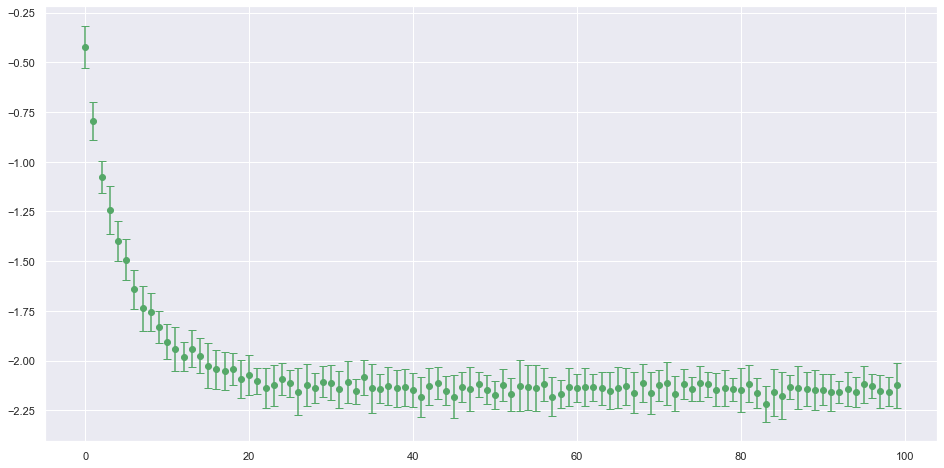

In [24]:
time=[t for t in range(len(qite_averages))]
plt.errorbar(time,qite_averages,yerr=qite_stds, capsize=4, fmt='go')